In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime

Using TensorFlow backend.


In [3]:
data = pd.read_csv('eth.csv')
data.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,31.Oct.17,307.38,310.55,305.88,305.88,"369,583,008.00","29,331,517,440.00"
1,1.Nov.17,305.76,306.40,290.58,291.69,"553,864,000.00","29,183,592,448.00"
2,2.Nov.17,290.73,293.91,281.17,287.43,"904,900,992.00","27,754,237,952.00"
3,3.Nov.17,288.50,308.31,287.69,305.71,"646,339,968.00","27,547,410,432.00"
4,4.Nov.17,305.48,305.48,295.80,300.47,"416,479,008.00","29,175,347,200.00"


In [4]:
high_prices = data['High'].values
low_prices = data['Low'].values
mid_prices = (high_prices + low_prices) / 2
seq_len = 50
sequence_length = seq_len + 1

result = []
for index in range(len(mid_prices) - sequence_length):
    result.append(mid_prices[index: index + sequence_length])

In [5]:
def normalize_windows(data):
    normalized_data = []
    for window in data:
        normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalized_data.append(normalized_window)
    return np.array(normalized_data)

result = normalize_windows(result)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((283, 50, 1), (31, 50, 1))

In [6]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))

model.add(LSTM(64, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop')

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


In [7]:
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=20,
    callbacks=[
        TensorBoard(log_dir='logs/%s' % (start_time)),
        ModelCheckpoint('./models/%s_eth.h5' % (start_time), monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='auto')
])

Instructions for updating:
Use tf.cast instead.
Train on 283 samples, validate on 31 samples
Epoch 1/20
283/283 [==============================] - 2s 9ms/step - loss: 0.0768 - val_loss: 0.0028

Epoch 00001: val_loss improved from inf to 0.00278, saving model to ./models/2019_04_05_20_13_26_eth.h5


OSError: Unable to create file (unable to open file: name = './models/2019_04_05_20_13_26_eth.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 302)

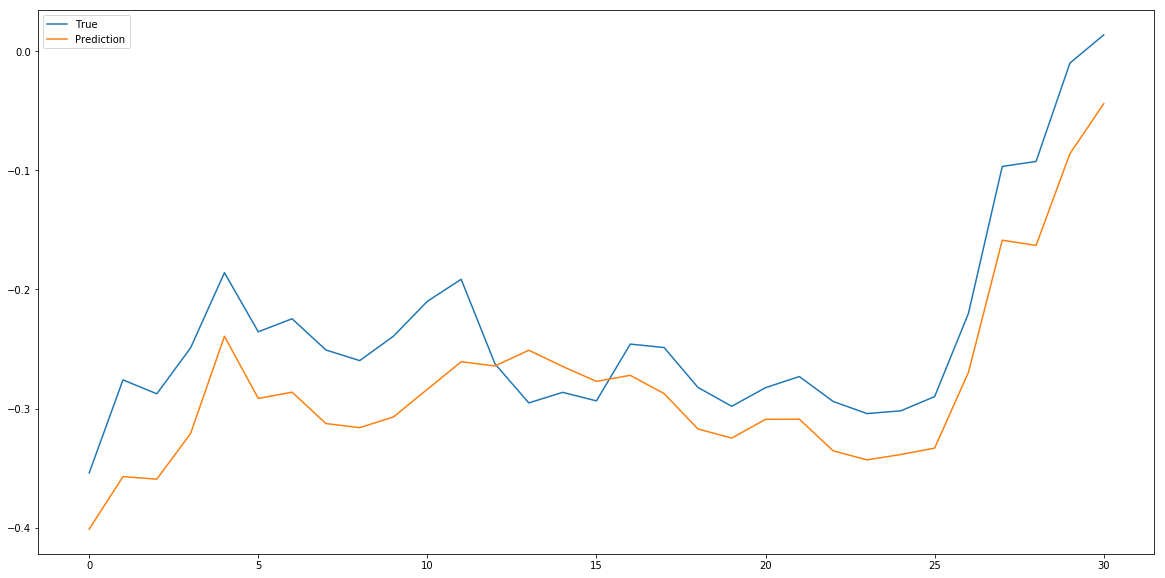

In [8]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()